# XID+SED Example Run Script

(This is based on a Jupyter notebook, available in the [XID+ package](https://github.com/H-E-L-P/XID_plus/tree/master/docs/notebooks/examples/) and can be interactively run and edited)

XID+ is a probababilistic deblender for confusion dominated maps. It is designed to:

1. Use a MCMC based approach to get FULL posterior probability distribution on flux
2. Provide a natural framework to introduce additional prior information
3. Allows more representative estimation of source flux density uncertainties
4. Provides a platform for doing science with the maps (e.g XID+ Hierarchical stacking, Luminosity function from the map etc)

This notebook shows an example on how to run XID+ with an SED emulator on the GALFORM simulation of the COSMOS field
* SAM simulation (with dust) ran through SMAP pipeline_ similar depth and size as COSMOS



Import required modules

In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs
import seaborn as sns
import glob
from astropy.coordinates import SkyCoord

import sys
sys.path.append('/home/pearsonw/dev/XID_plus/')

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os

from xidplus.numpyro_fit.neuralnet_models import CIGALE_emulator_kasia

In [2]:
#Folder containing maps
imfolder=xidplus.__path__[0]+'/../test_files/'

pswfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PSW_hipe.fits.gz'#SPIRE 250 map
pmwfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PMW_hipe.fits.gz'#SPIRE 350 map
plwfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PLW_hipe.fits.gz'#SPIRE 500 map


#Folder containing prior input catalogue
catfolder=xidplus.__path__[0]+'/../test_files/'
#prior catalogue
prior_cat='lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits'


#output folder
output_folder='./'

Load in images, noise maps, header info and WCS information

In [3]:
#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3 #convert to mJy
nim250=hdulist[2].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3 #convert to mJy
nim350=hdulist[2].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header 
im500=hdulist[1].data*1.0E3 #convert to mJy
nim500=hdulist[2].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

Load in catalogue you want to fit (and make any cuts)

In [4]:
catalogue=Table.read(catfolder+prior_cat)
catalogue['ID']=np.arange(0,len(catalogue))
catalogue.add_index('ID')
# select only sources with 100micron flux greater than 50 microJy
sgood=catalogue['S100']>0.010
inra=catalogue['RA'][sgood]
indec=catalogue['DEC'][sgood]
inz=catalogue['Z_OBS'][sgood]

XID+ uses Multi Order Coverage (MOC) maps for cutting down maps and catalogues so they cover the same area. It can also take in MOCs as selection functions to carry out additional cuts. Lets use the python module pymoc to create a MOC, centered on a specific position we are interested in. We will use a HEALPix order of 15 (the resolution: higher order means higher resolution), have a radius of 100 arcseconds centered around an R.A. of 150.74 degrees and Declination of 2.03 degrees.

In [5]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=[150.74]*u.degree, dec=[2.03]*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,100,15)

XID+ is built around Python classes:
* A `prior class`: Contains all the information specific to a map being fitted (e.g. the map, noise map, a multi order coverage map, a prior positional catalogue, point spread function and pointing matrix)
* A `phys_prior` : Contains all the prior information on physical parameters( e.g. redshift, SFR etc), and the SED emulator

There should be a prior class for each map being fitted.It is initiated with a map, noise map, primary header and map header and can be set with a MOC. It also requires an input prior catalogue and point spread function.

In [6]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(inra,indec,prior_cat,ID=catalogue['ID'][sgood])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=moc)
prior350.prior_cat(inra,indec,prior_cat,ID=catalogue['ID'][sgood])
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=moc)
prior500.prior_cat(inra,indec,prior_cat,ID=catalogue['ID'][sgood])
prior500.prior_bkg(-5.0,5)

Set PRF. For SPIRE, the PRF can be assumed to be Gaussian with a FWHM of 18.15, 25.15, 36.3 '' for 250, 350 and 500 $\mathrm{\mu m}$ respectively. Lets use the astropy module to construct a Gaussian PRF and assign it to the three XID+ prior classes.

In [7]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires PRF as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [8]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+', '+ str(prior250.snpix)+' and '+ str(prior500.snpix)+' pixels')


fitting 101 sources 

using 870, 870 and 219 pixels


Before fitting, the prior classes need to take the PRF and calculate how much each source contributes to each pixel. This process provides what we call a pointing matrix. Lets calculate the pointing matrix for each prior class

In [9]:
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()

In [10]:
priors=[prior250,prior350,prior500]

To create the `phys_prior` class, you need to provide a table with some prior information for the physical parameters that contains the following:
* an ID column, `ID` that matches the `ID` in the prior class
* an `log10SFR_mu` and `log10SFR_sig` column that contains the mean and standard deviation for a Normal prior distribution
* an `z_mu` and `z_sig` column that contains the mean and standard deviation for a Normal prior distribution (truncated at 0.01 so not to go too small)
* a `fracAGN_alpha` and `fracAGN_beta` column that contains the alpha and beta values for a Beta prior distribution (i.e. that is constrained to be between 0 and 1
* a `atten_mu` and `atten_sig` column that contains the mean and standard deviation for a Normal prior distribution,
* a `dust_alpha_mu` and `dust_alpha_sig` column that contains the mean and standard deviation for a Normal prior distribution 
* a `tau_main_mu` and `tau_main_sig` column that contains the mean and standard deviation for a Normal prior distribution

In [11]:
phys_prior_table = Table([priors[0].ID,
                          np.full(priors[0].nsrc,1),
          np.full(priors[0].nsrc,1),
          catalogue.loc[priors[0].ID]['Z_OBS'].data,
          catalogue.loc[priors[0].ID]['Z_OBS'].data*0.1,
          np.full(priors[0].nsrc,1.0),
          np.full(priors[0].nsrc,3.0),
          np.full(priors[0].nsrc,1.95),
          np.full(priors[0].nsrc,1.0),
          np.full(priors[0].nsrc,2),
          np.full(priors[0].nsrc,1),
          np.full(priors[1].nsrc,3.5),
          np.full(priors[1].nsrc,0.25)
          ],
          names=('ID','log10SFR_mu', 'log10SFR_sig', 'z_mu', 'z_sig','fracAGN_alpha','fracAGN_beta','atten_mu','atten_sig','dust_alpha_mu','dust_alpha_sig','tau_main_mu','tau_main_sig'),
          meta={'name': 'phys prior table'},
                        dtype=[np.longlong]+[float for i in range(0,12)])
phys_prior_table.add_index('ID')

In [12]:
phys_prior_table

ID,log10SFR_mu,log10SFR_sig,z_mu,z_sig,fracAGN_alpha,fracAGN_beta,atten_mu,atten_sig,dust_alpha_mu,dust_alpha_sig,tau_main_mu,tau_main_sig
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8177,1.0,1.0,2.1290905475616455,0.2129090577363968,1.0,3.0,1.95,1.0,2.0,1.0,3.5,0.25
8179,1.0,1.0,2.127817392349243,0.21278174221515656,1.0,3.0,1.95,1.0,2.0,1.0,3.5,0.25
8206,1.0,1.0,2.1299428939819336,0.2129942923784256,1.0,3.0,1.95,1.0,2.0,1.0,3.5,0.25
8215,1.0,1.0,2.126209259033203,0.21262092888355255,1.0,3.0,1.95,1.0,2.0,1.0,3.5,0.25
11643,1.0,1.0,1.0341293811798096,0.1034129410982132,1.0,3.0,1.95,1.0,2.0,1.0,3.5,0.25
20716,1.0,1.0,1.437013864517212,0.14370138943195343,1.0,3.0,1.95,1.0,2.0,1.0,3.5,0.25
22635,1.0,1.0,2.521920919418335,0.25219210982322693,1.0,3.0,1.95,1.0,2.0,1.0,3.5,0.25
22636,1.0,1.0,2.522642135620117,0.25226423144340515,1.0,3.0,1.95,1.0,2.0,1.0,3.5,0.25
22638,1.0,1.0,2.522317886352539,0.25223180651664734,1.0,3.0,1.95,1.0,2.0,1.0,3.5,0.25


The `phys_prior` class takes in the phys prior table, the model emulator, the path to the emulator parameters file, and dictionary with parameters for the hierarchical model (in this case a schecter like function)

In [13]:
hier_params={'z_star_mu':4.0,'z_star_sig':0.3,'sfr_star_mu':7,'sfr_star_sig':2.0,'sfr_disp':0.5,'alpha':0.5}

emulator_path=xidplus.__path__[0]+'/emulator/params/CIGALE_emulator_kasia_20220127.npz'

phys_prior=xidplus.hier_prior(phys_prior_table,CIGALE_emulator_kasia,emulator_path,hier_params)

In [14]:
from numpyro.infer import Predictive
from jax import random, vmap
from xidplus.numpyro_fit import SED_prior

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [15]:
## For numpyro to sample from the prior, the data needs to be set to None
import copy
#make a deepcopy of the priors
priors_prior_pred=copy.deepcopy(priors)
#set data to None
for i in range(0,len(priors)):
    priors_prior_pred[i].sim=None

In [16]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive=Predictive(SED_prior.spire_model_CIGALE_kasia_schect,posterior_samples = {}, num_samples = 1000,)
prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior)

CPU times: user 5.06 s, sys: 126 ms, total: 5.19 s
Wall time: 4.96 s


## First pass

In [17]:
import numpyro
from numpyro.diagnostics import summary
import jax.numpy as jnp
from numpyro.infer import NUTS,MCMC
import os
numpyro.set_host_device_count(4)
from operator import attrgetter

def fit_model(priors,phys_prior,num_samples=500, num_warmup=500,num_chains=4,chain_method='parallel'):
    nuts_kernel = NUTS(SED_prior.spire_model_CIGALE_kasia_schect,init_strategy=numpyro.infer.init_to_median())
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup,num_chains=num_chains,chain_method=chain_method)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key,priors,phys_prior)
    return mcmc

In [18]:
n_chains=2
mcmc=fit_model(priors,phys_prior,num_samples=100, num_warmup=500,num_chains=n_chains,chain_method='parallel')

sample: 100%|██████████| 600/600 [02:31<00:00,  3.97it/s, 255 steps of size 1.35e-02. acc. prob=0.89] 


In [19]:
from operator import attrgetter
from numpyro.diagnostics import summary
import jax.numpy as jnp
import os
samples=mcmc.get_samples()
divergences=mcmc.get_extra_fields()['diverging']
prob = 0.9
exclude_deterministic = True
sites = mcmc._states[mcmc._sample_field]
if isinstance(sites, dict) and exclude_deterministic:
    state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
    # XXX: there might be the case that state.z is not a dictionary but
    # its postprocessed value `sites` is a dictionary.
    # TODO: in general, when both `sites` and `state.z` are dictionaries,
    # they can have different key names, not necessary due to deterministic
    # behavior. We might revise this logic if needed in the future.
    if isinstance(state_sample_field, dict):
        sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                 if k in state_sample_field}

stats_summary = summary(sites, prob=prob)

## Check diagnostics
When running any MCMC algorithm, you need to check that it has explored the full posterior probability space, and not got stuck in local minima. The standard MCMC diagnostics are:
* $\hat{R}$ compares variation within and between chains. You want $\hat{R} < 1.1$
* $n_{eff}$ effective sample size which is a measure of autocorrelation within the chains. More autocorrelation increases uncertainty in estimates. Typical MCMC has a low $n_{eff}$ and requires thinning (as to keep all samples would be too memory intensive). Since NUTS HMC is efficient, there is little need to chuck samples away. If $n_{eff} / N < 0.001$, then there is a problem with model

The other diagnostic, exclusive to The NUTS sampler, is the identification of `divergent transitions`. These identify areas in parameter space where because of some the gradient is very different to the rest of parameter space, such that the tuned NUTS sampler cannot perform its next step accuractely. These tend to occur in funnel like or VERY correlated posterior spaces. Another good explanation can be found [here](https://dev.to/martinmodrak/taming-divergences-in-stan-models-5762). If many `divergent transitions` are found, the posterior cannot be trusted and some reparamaterisation is required. Note: Standard MCMC algorithms cannot identify divergent transitions, but that does not mean they do not occur.

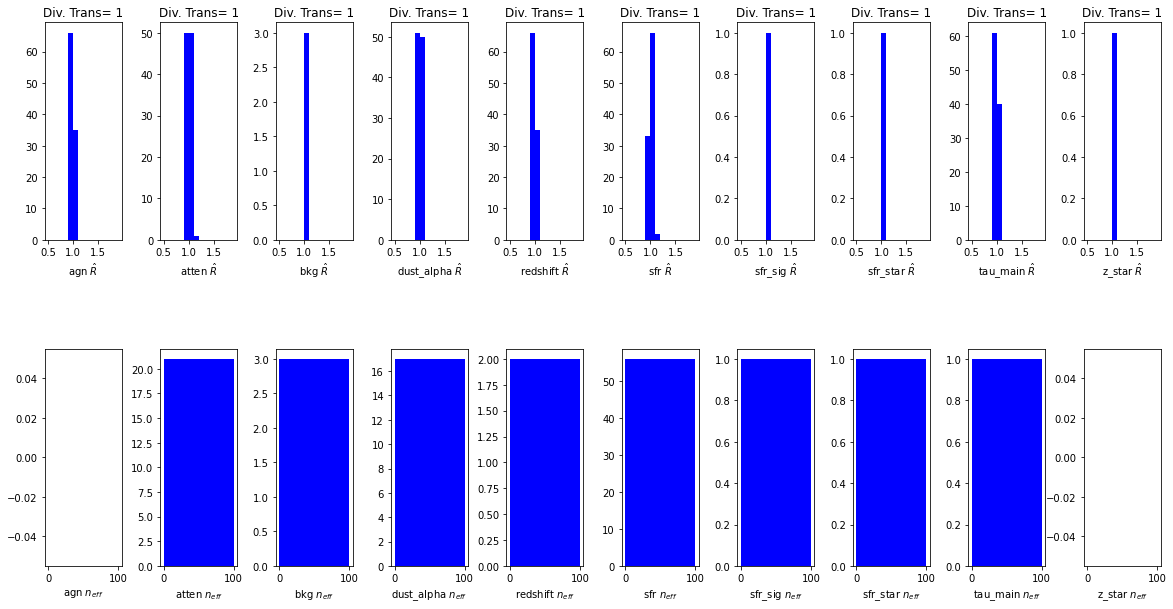

In [20]:
fig,axes=plt.subplots(2,len(samples),figsize=(2*len(samples),10))
for i,k in enumerate(samples):

    axes[0,i].hist(stats_summary[k]['r_hat'].flatten(),color='Blue',bins=np.arange(0.5,2,0.1))
    axes[1,i].hist(stats_summary[k]['n_eff'].flatten(),color='Blue',bins=np.arange(0,samples['z_star'].shape[0],100))
    axes[0,i].set_xlabel(k+' $ \hat{R}$')
    axes[0,i].set_title('Div. Trans= {}'.format(np.sum(divergences)))
    axes[1,i].set_xlabel(k+' $ n_{eff}$')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

All diagnostics look fine. 

## Posterior Probability distributions

#### Hierarchical parameters

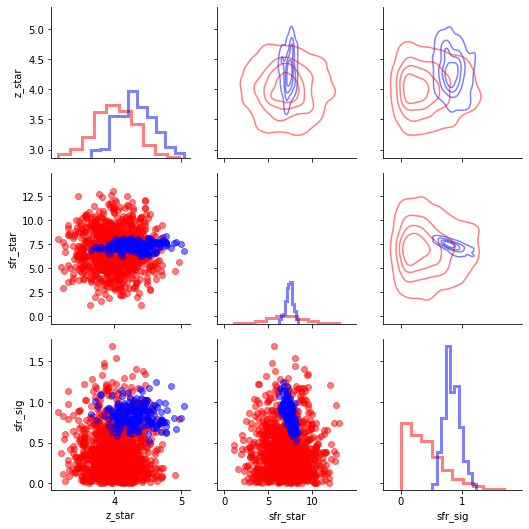

In [21]:
import pandas as pd
hier_param_names=['z_star','sfr_star','sfr_sig']

df_prior=pd.DataFrame(np.array([prior_pred[s] for s in hier_param_names]).T,columns=hier_param_names)
g=sns.PairGrid(df_prior)
g.map_lower(plt.scatter,alpha=0.5,color='Red')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Red',density=True)

df_post=pd.DataFrame(np.array([samples[s] for s in hier_param_names]).T,columns=hier_param_names)
g.data=df_post
g.map_lower(plt.scatter,alpha=0.5,color='Blue')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Blue',density=True)
g.map_upper(sns.kdeplot,alpha=0.5,color='Blue',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#for some reason the contour plots will delete other plots so do last
g.data=df_prior
g.map_upper(sns.kdeplot,alpha=0.5,color='Red',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

In [22]:
def Schecter(zstar,alpha,sfr_star,z):
    return (sfr_star*(z/zstar)**alpha)*np.exp(-z/zstar)-2

Text(0, 0.5, '$\\log_{10}$ SFR')

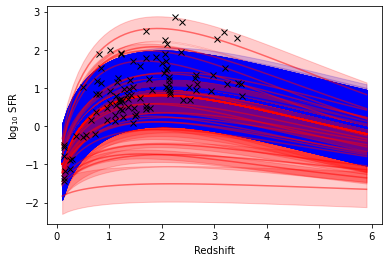

In [23]:
z=np.arange(0.1,6,0.1)
for i in range(0,2000,50):
    if samples['z_star'][i]<3:
        col='g'
    else:
        col='b'
    plt.plot(z,Schecter(prior_pred['z_star'][i],phys_prior.hier_params['alpha'],prior_pred['sfr_star'][i],z),'r',alpha=0.5)
    plt.fill_between(z,Schecter(prior_pred['z_star'][i],phys_prior.hier_params['alpha'],prior_pred['sfr_star'][i],z)-prior_pred['sfr_sig'][i],
             Schecter(prior_pred['z_star'][i],phys_prior.hier_params['alpha'],prior_pred['sfr_star'][i],z)+prior_pred['sfr_sig'][i],color='r',alpha=0.2)
    plt.fill_between(z,Schecter(samples['z_star'][i],phys_prior.hier_params['alpha'],samples['sfr_star'][i],z)-samples['sfr_sig'][i],Schecter(samples['z_star'][i],phys_prior.hier_params['alpha'],samples['sfr_star'][i],z)+samples['sfr_sig'][i],color=col,alpha=0.2)
    plt.plot(z,Schecter(samples['z_star'][i],phys_prior.hier_params['alpha'],samples['sfr_star'][i],z),col,alpha=0.9)


    
plt.plot(np.median(samples['redshift'],axis=0),np.median(samples['sfr'],axis=0),'kx')
plt.xlabel('Redshift')
plt.ylabel(r'$\log_{10}$ SFR')

#### Source parameters 

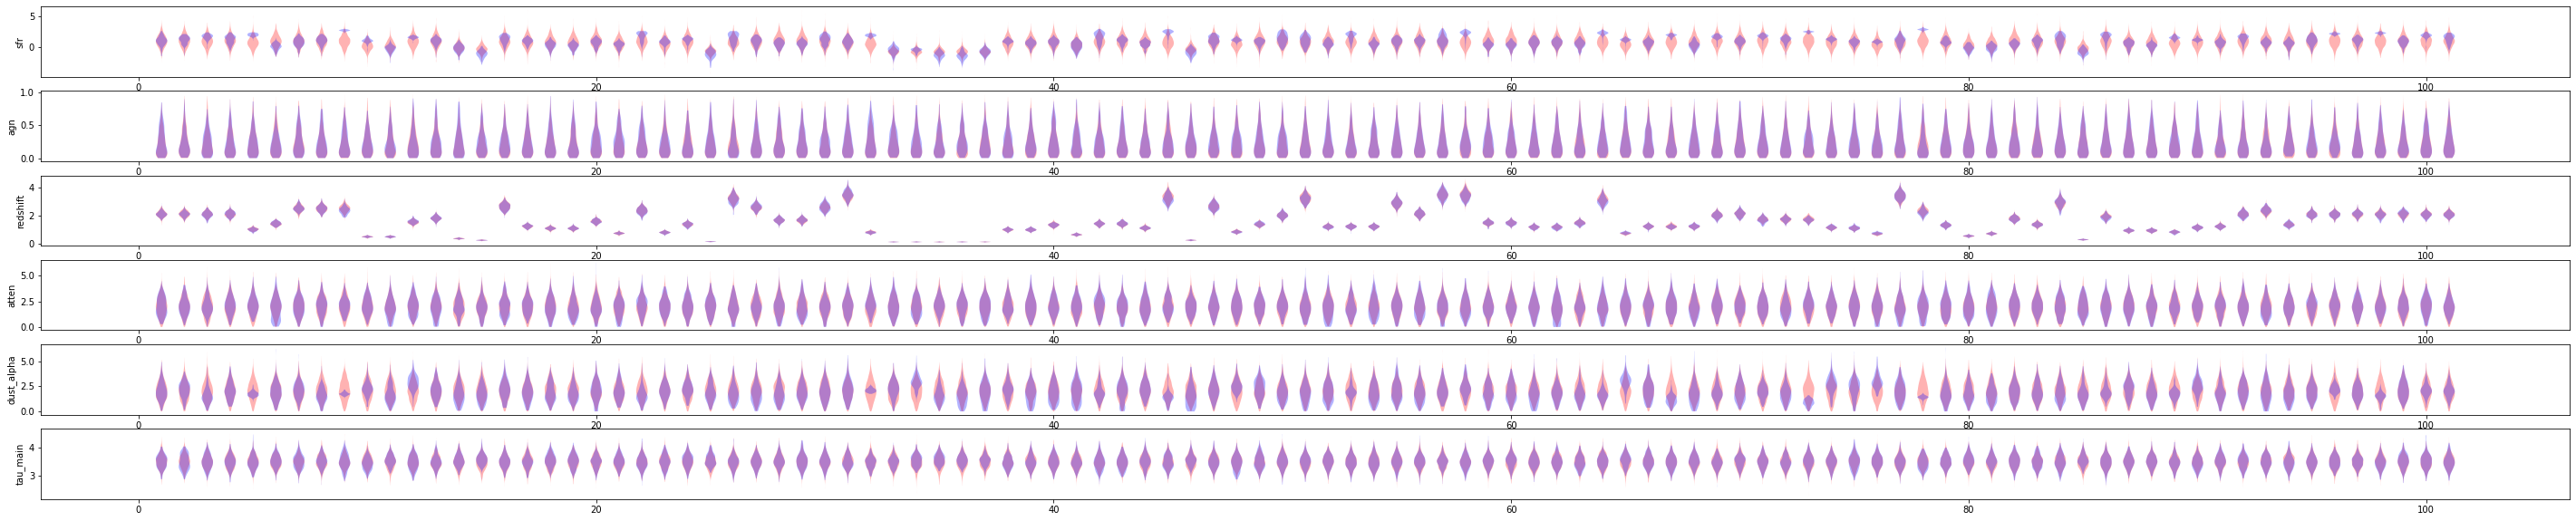

In [24]:
phys_params=['sfr','agn','redshift','atten','dust_alpha','tau_main']
fig,axes=plt.subplots(len(phys_params),1,figsize=(50,10))

for i ,p in enumerate(phys_params):
    v_plot=axes[i].violinplot(prior_pred[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Red')
    v_plot=axes[i].violinplot(samples[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Blue')
    axes[i].set_ylabel(phys_params[i])



### Posterior Predicitive Checks

In [25]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE_kasia_schect,posterior_samples = samples, num_samples = 50)
prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior)
mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]

CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.06 s


In order to compare how good our fit is, its often useful to look at original map. There is a routine within XID+ that makes the original fits map from the data stored within the prior class. Lets use that to make the SPIRE maps for the region we have fit.

Now lets use the [Seaborn](https://stanford.edu/~mwaskom/software/seaborn/index.html) plotting package and [APLpy](http://aplpy.readthedocs.io/en/stable/) package to view those maps, plotting the sources we have fit on top of those maps.

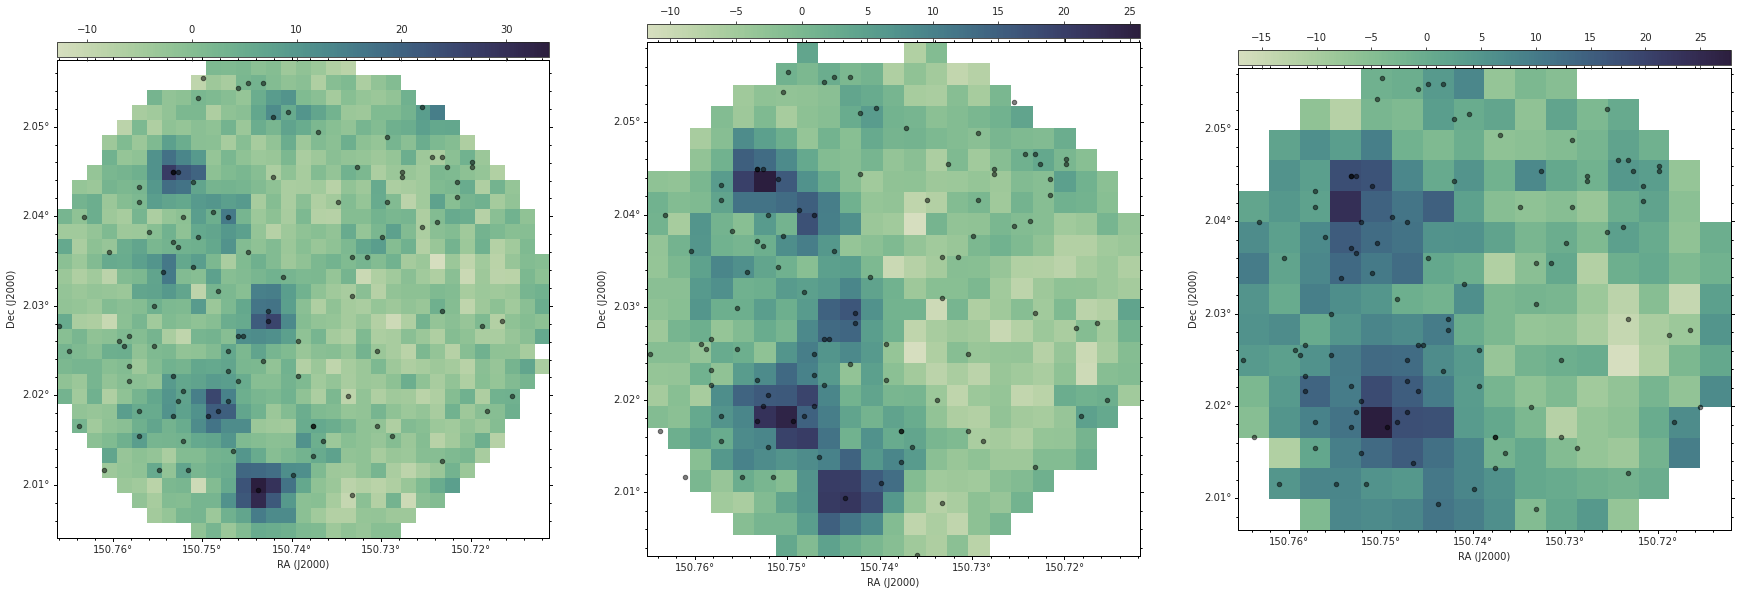

In [26]:
figures,fig=xidplus.plot_map(priors)

We can use each sample we have from the posterior, and use it to make a replicated map, including simulating the instrumental noise, and the estimated confusion noise. You can think of these maps as all the possible maps that are allowed by the data. 

> NOTE: You will require the `FFmpeg` library installed to run the movie

In [27]:
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors,mod_map_array_samp,50)

TypeError: __init__() got an unexpected keyword argument 'extra_args'

### Posterior Predictive checking and Bayesian P-value maps
When examining goodness of fits, the typical method is to look at the residuals. i.e. $\frac{data - model}{\sigma}$. Because we have distribution of $y^{rep}$, we can do this in a more probabilisitic way using posterior predictive checks. For more information on posterior predictive checks, [Gelman et al. 1996](http://www.stat.columbia.edu/~gelman/research/published/A6n41.pdf) is a good starting point.



For our case, the best way to carry out posterior predictive checks is to think about one pixel. We can look at where the real flux value for our pixel is in relation to the distribution from $y^{rep}$. 

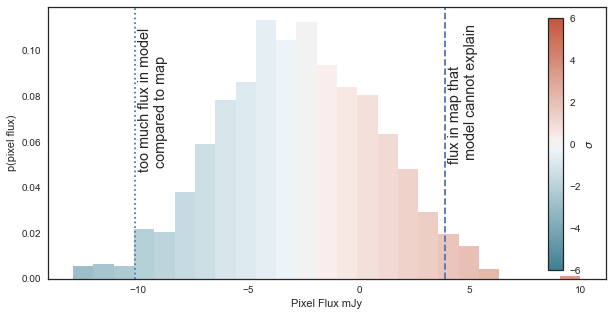

We can calculate fraction of $y^{rep}$ samples above and below real map value. This is often referred to as the Bayesian p-value and is telling us the probability of drawing the real pixel value, from our model which has been inferred on the data. This is tells us if the model is inconsistent with the data, given the uncertianties in parameters and data.

* $\sim 0.5$ means our model is consistent with the data 
* 0.99 or 0.01 means model is missing something.

We can convert this to a typical '$\sigma$' level and create map versions of these Bayesian p-values:

In [ ]:
from xidplus import postmaps
import aplpy
sns.set_style("white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
Bayes_pvals = []
hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
fig = plt.figure(figsize=(10 * len(priors), 10))
figs = []
for i in range(0, len(priors)):
    figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
    Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))
    
    
for i in range(0, len(priors)):
    figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                         marker='o', s=20, alpha=0.5)
    figs[i].tick_labels.set_xformat('dd.dd')
    figs[i].tick_labels.set_yformat('dd.dd')
    figs[i]._data[
        priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
    Bayes_pvals[i]
    figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
    figs[i].add_colorbar()
    figs[i].colorbar.set_location('top')

Red indicates the flux value in the real map is higher than our model thinks is possible. This could be indicating there is a source there that is not in our model.
Blue indicates the flux in the real map is lower than in our model. This is either indicating a very low density region or that too much flux has been assigned to one of the sources.

## Save the samples using arviz

In [ ]:
import arviz as az
numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior_pred,
    posterior_predictive=prior_pred_samp,
    coords={"src": np.arange(0,priors[0].nsrc),
           "band":np.arange(0,3)},
    dims={"agn": ["src"],
         "bkg":["band"],
         "redshift":["src"],
          "sfr":["src"]},
)
#stack params and make vector ready to be used by emualator
params = jnp.stack([i.values.reshape(numpyro_data.posterior.chain.size * numpyro_data.posterior.draw.size,numpyro_data.posterior.src.size).T for i in [numpyro_data.posterior.sfr,numpyro_data.posterior.agn,numpyro_data.posterior.redshift,numpyro_data.posterior.atten,numpyro_data.posterior.dust_alpha,numpyro_data.posterior.tau_main]]).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params)))

#stack params and make vector ready to be used by emualator
params_prior =  jnp.stack([i.values.reshape(numpyro_data.prior.chain.size * numpyro_data.prior.draw.size,numpyro_data.prior.src.size).T for i in [numpyro_data.prior.sfr,numpyro_data.prior.agn,numpyro_data.prior.redshift,numpyro_data.prior.atten,numpyro_data.prior.dust_alpha,numpyro_data.prior.tau_main]]).T

# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f_prior = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params_prior)))
dims=("chain", "draw","src", "band")
numpyro_data.posterior['src_f']=(dims,src_f[:,:,[-3,-2,-1]].reshape(numpyro_data.posterior.chain.size,numpyro_data.posterior.draw.size,numpyro_data.posterior.src.size,3))
numpyro_data.prior['src_f']=(dims,src_f_prior[:,:,[-3,-2,-1]].reshape(numpyro_data.prior.chain.size,numpyro_data.prior.draw.size,numpyro_data.prior.src.size,3))
numpyro_data.to_netcdf('xid+sed_sim_output.nc')